In [1]:
! pip install patchify

In [2]:
import os
import zipfile
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from tensorflow.keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

zip = zipfile.ZipFile('/content/drive/MyDrive/image_data/satelite-image-data.zip')
zip.extractall('/content/satellite')
zip.close()

In [5]:
os.chdir("/content/satellite/Semantic segmentation dataset")


In [6]:
!ls

 classes.json  'Tile 1'  'Tile 2'  'Tile 3'  'Tile 4'  'Tile 5'  'Tile 6'  'Tile 7'  'Tile 8'


In [7]:
dataset_root_folder = "/content/satellite"

In [8]:
dataset_name = "Semantic segmentation dataset"

In [9]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder,dataset_name)):
   dir_name = path.split(os.path.sep)[-1]
   #print(dir_name)
   if dir_name == "masks": # images
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith(".png")): # .jpg
        #print(image_name)
        a = True

/content/satellite/Semantic segmentation dataset/Tile 7/masks
/content/satellite/Semantic segmentation dataset/Tile 5/masks
/content/satellite/Semantic segmentation dataset/Tile 3/masks
/content/satellite/Semantic segmentation dataset/Tile 2/masks
/content/satellite/Semantic segmentation dataset/Tile 1/masks
/content/satellite/Semantic segmentation dataset/Tile 8/masks
/content/satellite/Semantic segmentation dataset/Tile 6/masks
/content/satellite/Semantic segmentation dataset/Tile 4/masks


In [10]:
image_patch_size = 256

In [11]:
image =cv2.imread(f"{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg",1)

In [12]:
print(image)

[[[ 57  72  81]
  [ 50  65  74]
  [ 72  84  94]
  ...
  [ 77  85 115]
  [ 77  86 124]
  [ 76  87 131]]

 [[ 53  67  79]
  [ 60  75  84]
  [ 82  94 106]
  ...
  [ 83  88 119]
  [ 76  85 123]
  [ 69  80 124]]

 [[ 67  78  92]
  [101 113 125]
  [107 116 130]
  ...
  [ 86  91 122]
  [ 84  91 130]
  [ 79  88 132]]

 ...

 [[111 107 102]
  [102  98  93]
  [ 85  81  76]
  ...
  [ 97  91  96]
  [105 101 106]
  [121 120 122]]

 [[127 124 119]
  [141 138 133]
  [135 133 125]
  ...
  [ 99  93  98]
  [109 105 110]
  [105 104 106]]

 [[163 163 157]
  [178 178 172]
  [159 157 149]
  ...
  [101  95 100]
  [111 107 112]
  [ 97  94  96]]]


In [13]:
image.shape

(544, 509, 3)

In [14]:
print(type(image))

<class 'numpy.ndarray'>


In [15]:
print(type(Image.fromarray(image)))

<class 'PIL.Image.Image'>


In [16]:
((image.shape[0])//image_patch_size)*image_patch_size

512

In [17]:
image_dataset = []
mask_dataset = []
minmaxscaler = MinMaxScaler()

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [18]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


In [19]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [20]:
image_dataset[0].shape

(256, 256, 3)

In [21]:
mask_dataset[0].shape

(256, 256, 3)

In [22]:


for i in range(0,5):
  random_image_id = random.randint(0, len(image_dataset))
  plt.figure(figsize=(14,8))
  plt.subplot(121)
  plt.imshow(image_dataset[random_image_id])
  plt.subplot(122)
  plt.imshow(mask_dataset[random_image_id])



Output hidden; open in https://colab.research.google.com to view.

In [23]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [24]:
label = individual_patched_mask

In [25]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [26]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [27]:
print(len(labels))

945


In [28]:
labels = np.array(labels)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
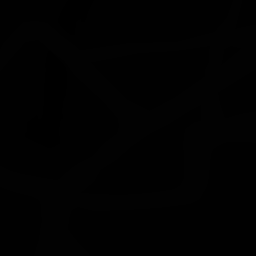

In [29]:
labels[3]

In [30]:
labels = np.expand_dims(labels, axis=3)

In [31]:

labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [32]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [33]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


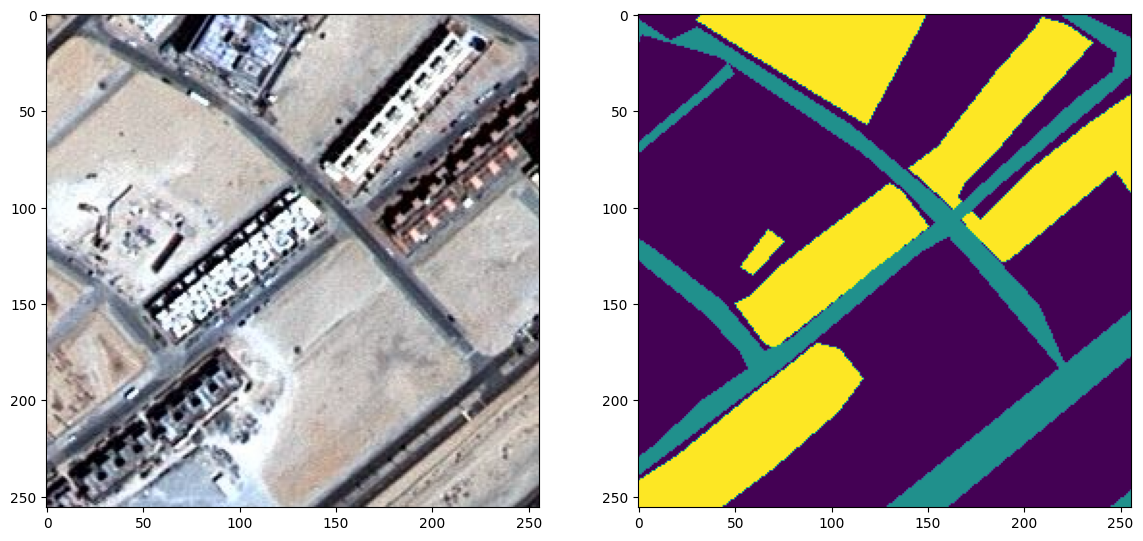

In [34]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
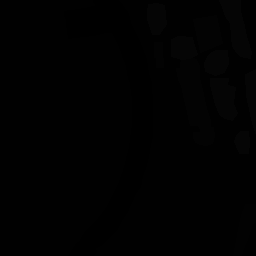

In [35]:
labels[0][:,:,0]

In [36]:
total_classes = len(np.unique(labels))
total_classes

6

In [37]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [38]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [39]:
master_trianing_dataset = image_dataset

In [40]:
master_trianing_dataset.shape

(945, 256, 256, 3)

In [41]:

from sklearn.model_selection import train_test_split

In [42]:

X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [43]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [44]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [45]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [46]:
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [47]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, concatenate, Dropout, Lambda

In [48]:
from keras import backend as k

In [49]:
def jaccard_coef(y_true, y_pred):

    y_true_flatten = k.flatten(y_true)
    y_pred_flatten = k.flatten(y_pred)
    intersection = k.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0)/ (k.sum(y_true_flatten) + k.sum(y_pred_flatten) - intersection + 1.0 )
    return final_coef_value

In [50]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6,c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7,c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8,c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9,c1], axis=3)
    c9 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model







In [51]:
metrics = ["accuracy", jaccard_coef]

In [52]:
def get_deep_learning_model ():
       return multi_unet_model(n_classes=total_classes,
                               image_height=image_height,
                               image_width=image_width,
                               image_channels=image_channels)

In [53]:
model = get_deep_learning_model()

In [54]:
model

In [55]:
#model.get_config()

In [56]:
weigths = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]

In [57]:
#!pip install segmentation-models

In [58]:
#import segmentation_models as sm


In [59]:
#dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [60]:
#focal_loss = sm.losses.CategoricalFocalLoss()

In [61]:
#total_loss = dice_loss + (1 * focal_loss)

In [62]:
import tensorflow as tf


In [63]:
tf.keras.backend.clear_session()


In [64]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=metrics)


In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [122]:
from keras.utils import plot_model
! pip install graphviz
! pip install pydot

In [123]:
plot_model(model,to_file="sateliite_model_plot.png",show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [68]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/50
51/51 [==============================] - 97s 2s/step - loss: 0.6332 - accuracy: 0.7712 - jaccard_coef: 0.5286 - val_loss: 0.7974 - val_accuracy: 0.7160 - val_jaccard_coef: 0.4655
Epoch 2/50
51/51 [==============================] - 97s 2s/step - loss: 0.6146 - accuracy: 0.7824 - jaccard_coef: 0.5391 - val_loss: 0.7636 - val_accuracy: 0.7435 - val_jaccard_coef: 0.4940
Epoch 3/50
51/51 [==============================] - 97s 2s/step - loss: 0.5952 - accuracy: 0.7951 - jaccard_coef: 0.5495 - val_loss: 0.7547 - val_accuracy: 0.7550 - val_jaccard_coef: 0.5172
Epoch 4/50
51/51 [==============================] - 97s 2s/step - loss: 0.5766 - accuracy: 0.8037 - jaccard_coef: 0.5631 - val_loss: 0.7589 - val_accuracy: 0.7497 - val_jaccard_coef: 0.5017
Epoch 5/50
51/51 [==============================] - 98s 2s/step - loss: 0.5580 - accuracy: 0.8120 - jaccard_coef: 0.5756 - val_loss: 0.8025 - val_accuracy: 0.7478 - val_jaccard_coef: 0.5263
Epoch 6/50
51/51 [==============================] 

In [70]:
history_a = model_history

In [71]:
history_a.history

{'loss': [0.6332146525382996,
  0.6146093606948853,
  0.5951784253120422,
  0.5766355395317078,
  0.5579754114151001,
  0.5408233404159546,
  0.5419548153877258,
  0.5128461718559265,
  0.49248194694519043,
  0.48784059286117554,
  0.46596065163612366,
  0.4630255401134491,
  0.4554799497127533,
  0.4695109724998474,
  0.4368581175804138,
  0.42916378378868103,
  0.4256272614002228,
  0.420698881149292,
  0.4712803363800049,
  0.4165568947792053,
  0.4030068814754486,
  0.399770587682724,
  0.38914528489112854,
  0.37813419103622437,
  0.3745957911014557,
  0.3640502989292145,
  0.36076730489730835,
  0.35530415177345276,
  0.3396712839603424,
  0.3421550393104553,
  0.341373473405838,
  0.3280368745326996,
  0.3170643746852875,
  0.30930930376052856,
  0.30985546112060547,
  0.3085499405860901,
  0.31454014778137207,
  0.30252909660339355,
  0.2896629869937897,
  0.2898620069026947,
  0.276583194732666,
  0.27864423394203186,
  0.2994052767753601,
  0.280426949262619,
  0.276511728763

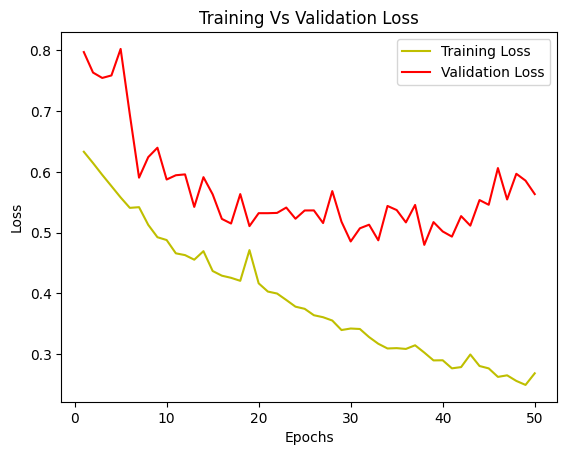

In [78]:
loss = history_a.history["loss"]
val_loss = history_a.history["val_loss"]
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,"y",label="Training Loss")
plt.plot(epochs,val_loss,"r",label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

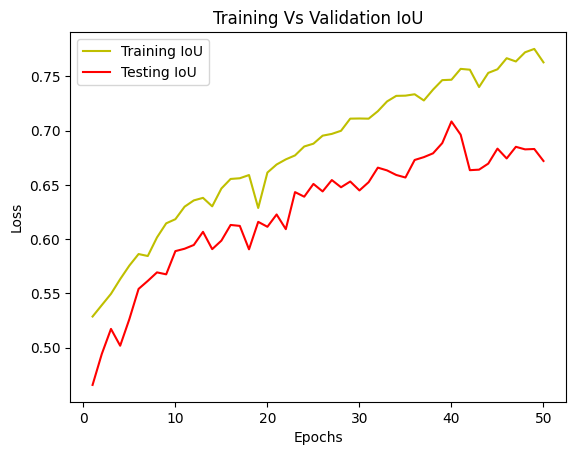

In [79]:
jaccard_coef= history_a.history["jaccard_coef"]
val_jaccard_coef = history_a.history["val_jaccard_coef"]


epochs = range(1,len(jaccard_coef)+1)
plt.plot(epochs,jaccard_coef,"y",label="Training IoU")
plt.plot(epochs,val_jaccard_coef,"r",label="Testing IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [80]:
history_a.params

{'verbose': 1, 'epochs': 50, 'steps': 51}

In [81]:
y_pred = model.predict(X_test)

5/5 [==============================] - 3s 457ms/step


In [82]:
len(y_pred)

142

In [85]:
y_pred_argmax = np.argmax(y_pred,axis=3)

In [86]:
len(y_pred_argmax)

142

In [87]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 2, ..., 1, 1, 1],
        [1, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [1, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 1, 4, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 

In [88]:
y_test_argmax = np.argmax(y_test,axis =3)

In [89]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [96]:
test_image_number = 10

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis =3)

1/1 [==============================] - 0s 55ms/step


In [97]:
predicted_image

array([[[4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        [4, 4, 4, ..., 1, 1, 1],
        ...,
        [1, 2, 2, ..., 4, 4, 1],
        [1, 1, 2, ..., 1, 1, 1],
        [1, 1, 2, ..., 1, 1, 1]]])

In [98]:
predicted_image = predicted_image[0,:,:]
predicted_image

array([[4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       ...,
       [1, 2, 2, ..., 4, 4, 1],
       [1, 1, 2, ..., 1, 1, 1],
       [1, 1, 2, ..., 1, 1, 1]])

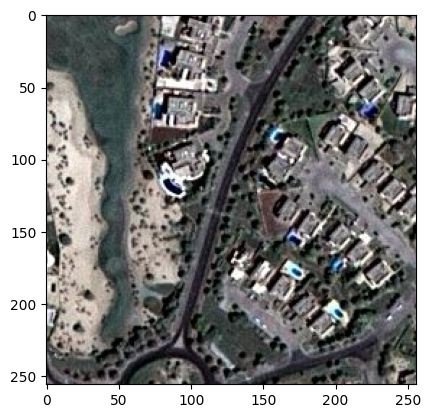

In [99]:
plt.imshow(test_image)

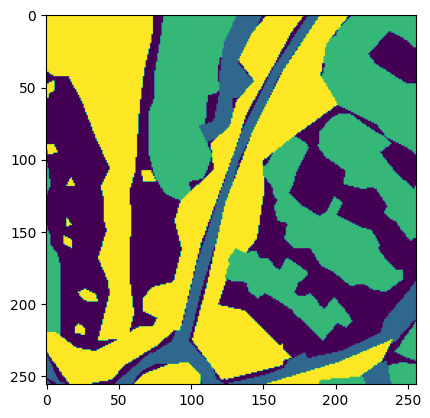

In [100]:
plt.imshow(ground_truth_image)

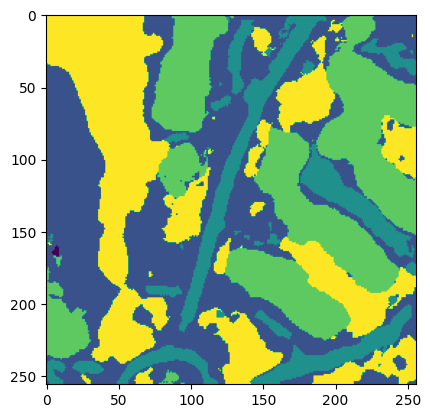

In [101]:
plt.imshow(predicted_image)

1/1 [==============================] - 0s 62ms/step


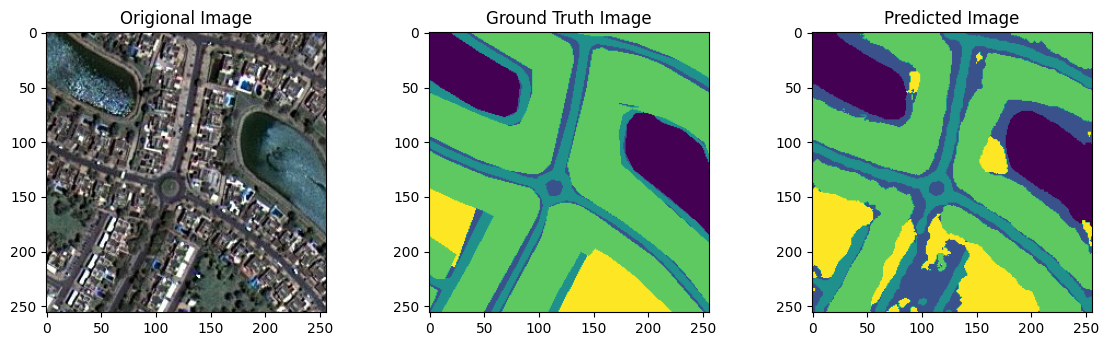

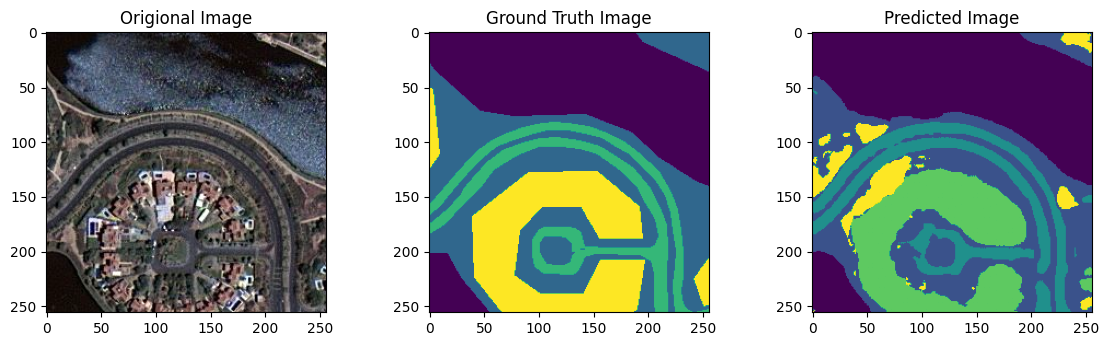

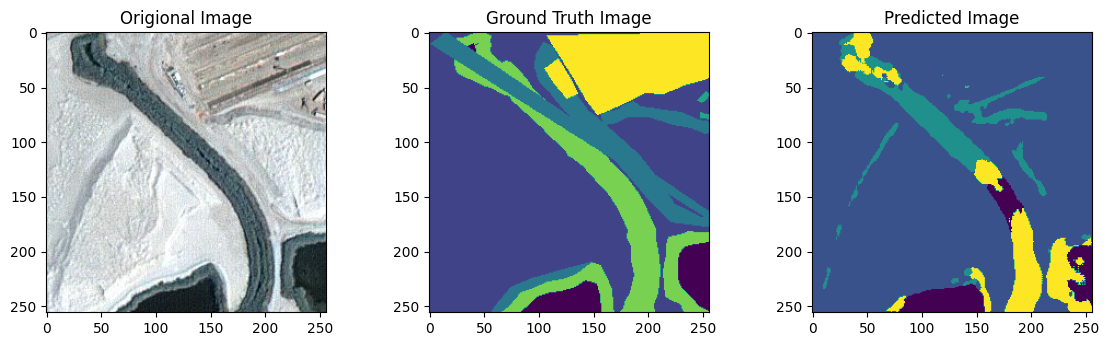

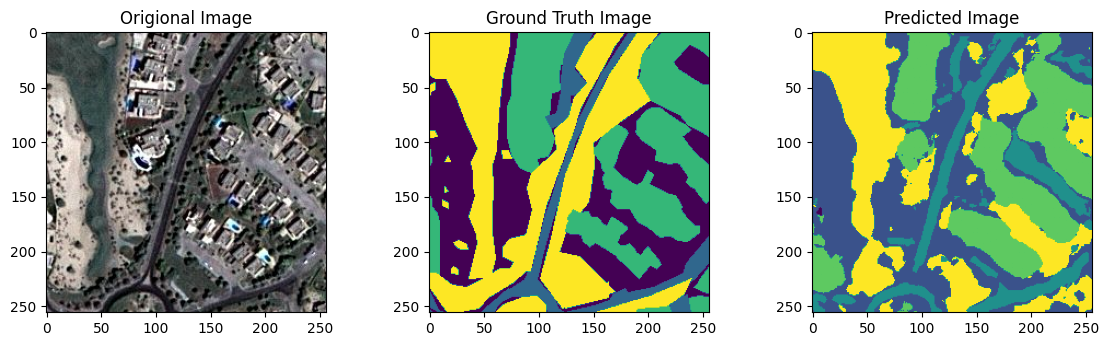

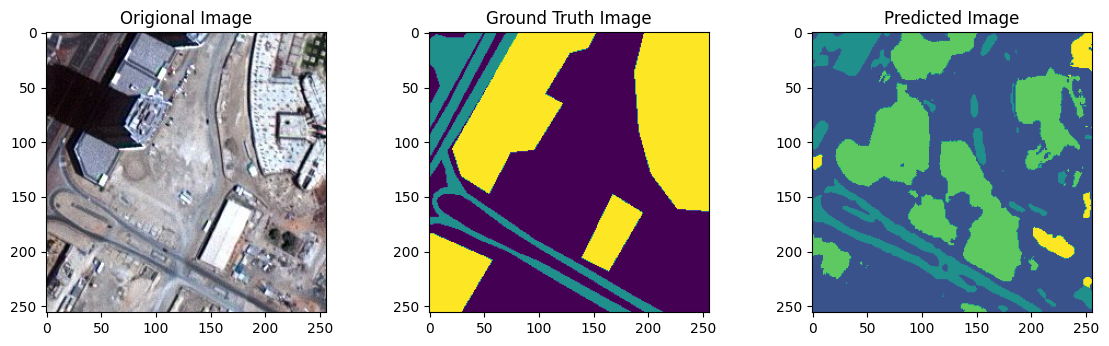

In [105]:
for i in range(0,5):
  test_image_number = random.randint(0, len(X_test))

  test_image = X_test[test_image_number]
  ground_truth_image = y_test_argmax[test_image_number]

  test_image_input = np.expand_dims(test_image, 0)

  prediction = model.predict(test_image_input)
  predicted_image = np.argmax(prediction, axis =3)
  predicted_image = predicted_image[0,:,:]

  plt.figure(figsize=(14,8))
  plt.subplot(231)
  plt.title("Origional Image")
  plt.imshow(test_image)
  plt.subplot(232)
  plt.title("Ground Truth Image")
  plt.imshow(ground_truth_image)
  plt.subplot(233)
  plt.title("Predicted Image")
  plt.imshow(predicted_image)

In [110]:
model_name = "satellite_segmentation_model"

model.save(f"/content/satellite/{model_name}.h5")
model.save(f"/content/satellite/{model_name}.keras")